# Searching for abdA in the assembled transcriptomes

Definitively proving the absence of a gene from a genome is a difficult task. However, one can make
some progress by gathering many kinds of indirect evidence. In this notebook, I will summarise the 
various sources of evidence for the absence of abdA from the genomic and transcriptomic repertoire
of _P. litorale_.

## 1. The genome assembly

Chelicerate and arthropod sequences were used to scan for the presence of the abdA homeobox in the
genome assembly. The homeoboxes were taken from the very helpful supplementary material of [Aase
Remedios _et al._ 2023](https://academic.oup.com/mbe/article/40/12/msad239/7341927) and supplemented
with xiphosuran, vinegaroon, and harvestman sequences.

We used `mmseqs2 easy-search` and specified the output format as follows: 

```bash
M8FORMAT="query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qlen"
```

We then used the following command to extract the best hits:

```bash
mmseqs easy-search chelicerate_abdA.fa ../draft.fasta chelicerate.m8 tmp  --format-output $M8FORMAT --threads 4
```

This search finished in approx. 2m. I will now use `pandas` and `matplotlib` to show an overview
of the results.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

a function to expedite reading the output file:

In [2]:
# read file, name columns
def read_aln(m8, id_sep=None):
    hox = pd.read_csv(m8, sep="\t", header=None)
    m8_columns = ['query', 'target', 'seq_id', 'ali_len', 'no_mism', 'no_go',
                'q_start', 'q_end', 't_start', 't_end', 'eval', 'bit', 'qlen']
    hox.columns = m8_columns
    # trim the query to just the ID
    if id_sep is not None:
        hox["query"] = hox["query"].str.split(id_sep).str[1]
    return hox

First, read the output table. This contains all hits that cross a lowest e-value threshold (10-3).

In [3]:
abda_loc = '/Volumes/scratch/pycnogonum/genome/draft/hox/chelicerate.m8'
abdA = read_aln(abda_loc)

best = abdA.sort_values('bit').drop_duplicates('query', keep='last')
best.set_index('query', inplace=True)

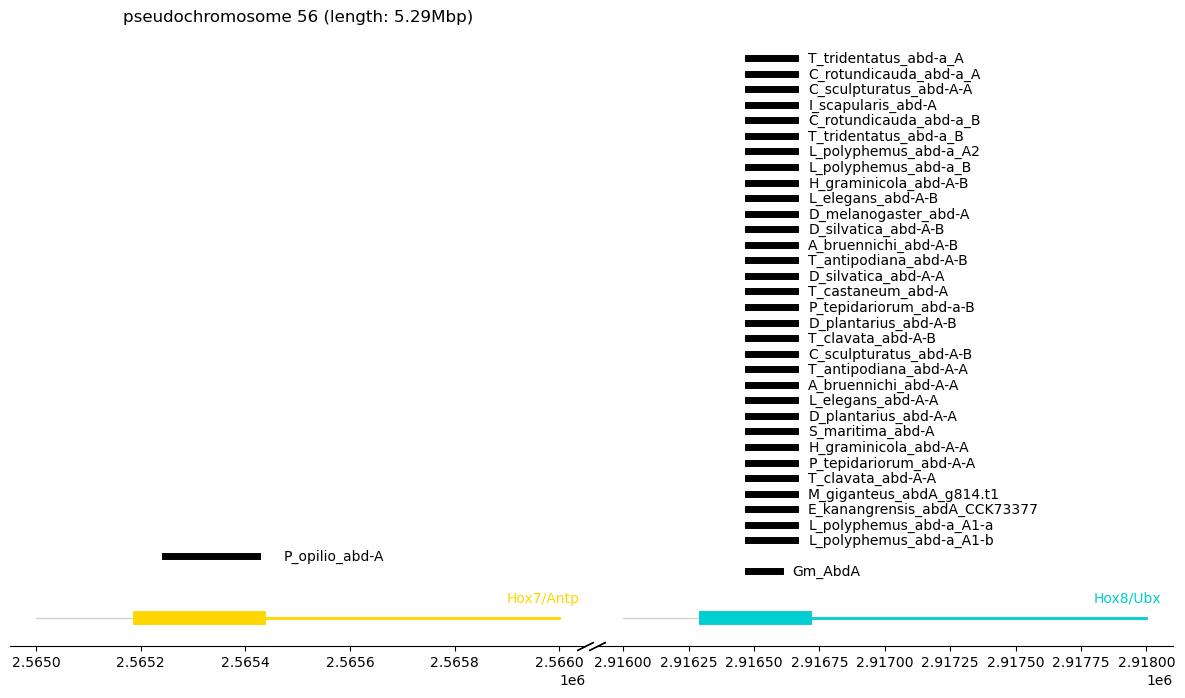

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8))
fig.subplots_adjust(wspace=0.02)

# plot contig
ax1_end = 2566000
ax2_end = 2918000
ax1.plot([2565000, ax1_end], [0, 0], color="lightgray", linewidth=1)
ax2.plot([2916000, ax2_end], [0, 0], color="lightgray", linewidth=1)


# ax2.plot([2926445, 2925945], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=10)
ax2.plot([2916697, 2916317], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=10)
ax2.plot([ax2_end, 2916317], [0, 0], color=mcolors.CSS4_COLORS["darkturquoise"], linewidth=2)
ax2.text(ax2_end-200, 1, "Hox8/Ubx", color=mcolors.CSS4_COLORS["darkturquoise"], fontsize=10)

# ax1.plot([2594468, 2593881], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=10)
ax1.plot([2565426, 2565199], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=10)
ax1.plot([ax1_end, 2565199], [0, 0], color=mcolors.CSS4_COLORS["gold"], linewidth=2)
ax1.text(ax1_end-100, 1, "Hox7/Antp", color=mcolors.CSS4_COLORS["gold"], fontsize=10)

i=3
for name, gene in best.iterrows():
    ax = ax1
    if gene["t_start"] > 2800000:
        ax = ax2
    ax.plot([gene["t_start"], gene["t_end"]], [i, i], color="black", linewidth=5)
    ax.text(gene["t_start"]+50, i-0.3, gene.name, color="black", fontsize=10)
    i += 1

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 0], transform=ax2.transAxes, **kwargs)

for ax in [ax1, ax2]:
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
ax1.set_title(f"pseudochromosome 56 (length: 5.29Mbp)");

fig.savefig("/Users/npapadop/Documents/presentations/2024-08_pygno_paper/suppl-abdA_chelicerata.png", dpi=300)

The majority of best hits for the abdA homeobox fall on the Ubx gene, except for the _Phalangium_
sequence, which finds Antp. On the genomic level, there seems to be no locus that corresponds to
abdA.

## 2. The transcriptome assembly

We will now search all the _de novo_ assembled transcriptomes from developmental stages with deeper
sequencing for any evidence of abdA. We will use the same homeobox sequences as before, and save the
results of each search in a separate file.

```bash
cd /Volumes/scratch/pycnogonum/genome/draft/hox/

for pep in ../transcriptome/*/Trinity.fasta.transdecoder.pep; do
    stage=$(echo $pep | cut -d"/" -f3);
    mmseqs easy-search chelicerate_abdA.fa $pep abdA_$stage.m8 tmp --format-output $M8FORMAT --threads 4
done
```

In [8]:
best_abdA = {}

deep_dev_transcriptomes = ["INSTAR1", "INSTAR3", "INSTAR5", "JUV1", "EMBRYO3", "INSTAR2", "INSTAR4", "INSTAR6", "SUBADULT"]

for stage in deep_dev_transcriptomes:
    abda_txome_loc = f'/Volumes/scratch/pycnogonum/genome/draft/hox/abdA_{stage}.m8'
    abdA = read_aln(abda_txome_loc)

    top_hits = abdA[abdA['eval'] < 1e-20]
    best_abdA[stage] = top_hits['target'].unique()

Now we can go and grab the sequences of the best hits for each stage, and then put them in a single
gene tree with all the other abdA sequences as well as other chelicerate Hox genes.

First, let's make sure an empty file exists that can receive the _Pycnogonum_ abdA candidate
sequences:

In [12]:
!rm /Volumes/scratch/pycnogonum/genome/draft/hox/abdA_candidates.fa
!touch /Volumes/scratch/pycnogonum/genome/draft/hox/abdA_candidates.fa

Now we can scrape the one-line-formatted transcriptome files for the best abdA hits:

In [14]:
with open('/Volumes/scratch/pycnogonum/genome/draft/hox/abdA_candidates.fa', 'w') as f:
    for stage, genes in best_abdA.items():
        fasta = f'/Volumes/scratch/pycnogonum/genome/draft/transcriptome/{stage}/oneline.fasta'
        for gene in genes:
            tmp = !grep -A 1 {gene} {fasta}
            tmp[0] = f'>{stage}_{gene}'
            f.write("\n".join(tmp) + "\n")

This will be very redundant, so we will collapse identical sequences, and keep track of the
transcript IDs in the FASTA header of each sequence.

The way to do this is to read the sequences into a `pandas` DataFrame...

In [15]:
current_id = ""
sequences = {}

with open('/Volumes/scratch/pycnogonum/genome/draft/hox/abdA_candidates.fa', 'r') as f:
    for line in f.readlines():
        if line.startswith(">"):
            current_id = line[1:].strip()
        else:
            sequences[current_id] = line.strip()

abdA_df = pd.DataFrame(sequences.items(), columns=["id", "seq"])

...group by sequence, concatenate the transcript IDs, ...

In [36]:
tmp = abdA_df.groupby("seq").apply(lambda x: ",".join(x["id"].values), include_groups=False)
collapsed = pd.DataFrame(tmp)

transcript_groups = [str.format("group_{0:02d}", i) for i in range(1, len(collapsed)+1)]
collapsed['seq'] = collapsed.index
collapsed.index = transcript_groups

...and finally write the collapsed sequences to a new FASTA file.

In [41]:
with open('/Volumes/scratch/pycnogonum/genome/draft/hox/abdA_candidates_collapsed.fa', 'w') as f:
    for group, row in collapsed.iterrows():
        f.write(f">{group} {row[0]}\n")
        f.write(f"{row['seq']}\n")

All the transcripts are already in-frame, and were translated on the University of Birmingham
[bioinformatics server](https://www.bioinformatics.org/sms2/translate.html).

Now we can calculate the multiple sequence alignment and the gene tree for the putative abdA
sequences.